In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

from IPython import display
%matplotlib inline

import pickle

In [157]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [158]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [159]:
from tqdm import tqdm, tqdm_notebook
import time

In [160]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [197]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [198]:
x = tf.placeholder("float", shape=[None, None, None, 1])

In [199]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

out = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [200]:
target = tf.placeholder("float", shape=[None, None, None, 1])
#loss_mask = tf.placeholder("float", shape=[None, None, None, 1])
lr = tf.placeholder('float')

In [201]:
#loss = tf.reduce_mean(tf.losses.log_loss(target, out, weights=loss_mask))

loss = tf.reduce_mean(tf.losses.log_loss(target, out))
#loss = mean_iou(out, target)

In [202]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta2=0.98)
train_step = optimizer.minimize(loss)

In [203]:
uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.initialize_variables(uninitialized_vars)
sess.run(init_new_vars_op)

In [204]:
#X = np.save("../../data/simulation/1000_35_like_true/populations", synthetic_populations)
y = np.load("../data/simulation/1000_35_like_true/populations_gr.npy")[:, :32, :32]
X = np.load("../data/simulation/1000_35_like_true/amp_gr.npy")[:, :32, :32] 
#json.dump(params, open("../../data/simulation/1000_35_like_true/params.json", 'w'))

In [205]:
def norm(x):
    maxes = x.max(2)
    maxes[maxes == 0] = 1
    #print(maxes.astype(int))
    return x / maxes.reshape(x.shape[0], x.shape[1], 1)

In [206]:
X_n = norm(X)
y_n = (y > 0).astype(int)

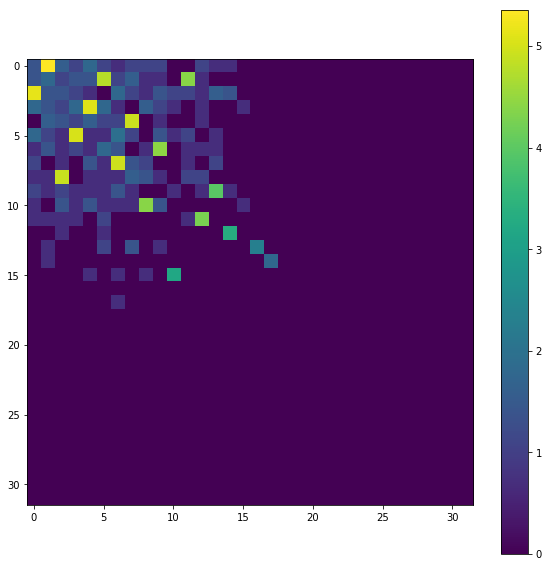

In [207]:
plot_gr(X[1], log = 1)

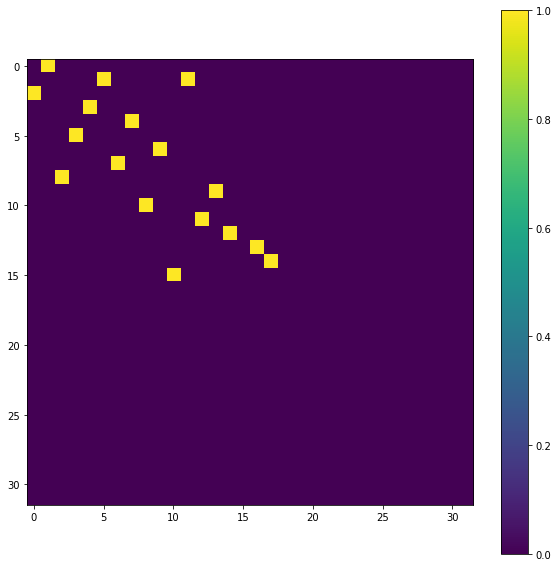

In [208]:
plot_gr(y_n[1])

In [209]:
def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, x.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [210]:
train_loss = []
val_scores = []
val_loss = []

In [211]:
epochs = 10
l_r = 0.001

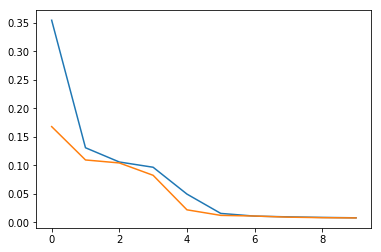

In [212]:

for epoch in range(epochs):
    curr_loss = 0
    for i, (batch_x, batch_y) in tqdm(enumerate(iterate_minibatches(X_n[:800], y_n[:800], 20))):

        batch_x = np.expand_dims(batch_x, 3)
        batch_y = np.expand_dims(batch_y, 3)
        batch_loss = sess.run([train_step,loss], feed_dict={x : batch_x,
                                                            target: batch_y,
                                                            #loss_mask: (batch_y + 1),
                                                            lr : l_r})
        curr_loss += batch_loss[1]
        #print(curr_loss)

    train_loss.append(curr_loss / (i + 1)) 
    
#     val_score = validate_simple(val_data, predict)            
#     val_scores.append(val_score)
    
    
    
    curr_loss = 0
    for i, (batch_x, batch_y) in tqdm(enumerate(iterate_minibatches(X_n[800:], y_n[800:], 20))):
        batch_x = np.expand_dims(batch_x, 3)
        batch_y = np.expand_dims(batch_y, 3)
        batch_loss = sess.run([loss], feed_dict={x : batch_x,
                                                 target: batch_y,
                                                 #loss_mask: (batch_y + 1),
                                                 lr : l_r})
        curr_loss += batch_loss[0]
        #print(curr_loss)

    val_loss.append(curr_loss / (i + 1))
    
    
    #val_loss.append(sess.run(loss, feed_dict={x:X_n, target:val_y, loss_mask:val_mask}))
   
    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    #plt.plot(val_scores, label='test')
    plt.plot(val_loss, label='test')

    plt.show()
            

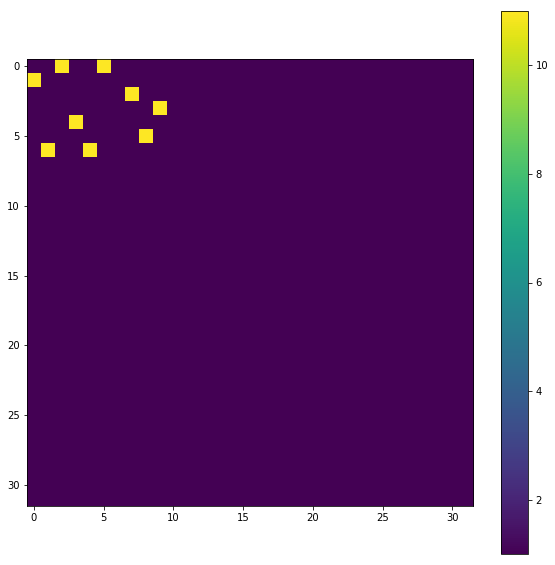

In [213]:
plot_gr((batch_y * 10 + 1)[0,:,:,0])

In [214]:
pred = sess.run(out, feed_dict={x : np.expand_dims(X_n[800:], 3)})[:,:,:,0]

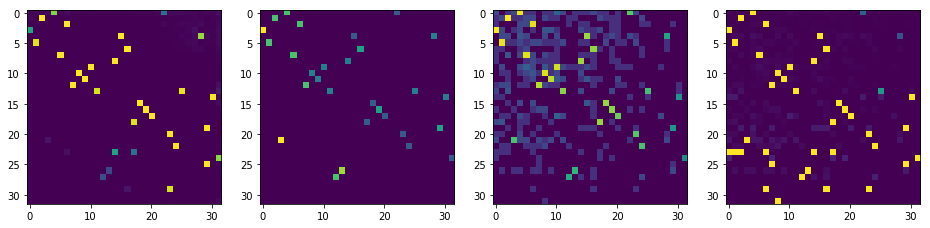

In [215]:
plot_group(pred[1], 0, y[801], 0, X[801], 1, X_n[801], 0, s = 16)

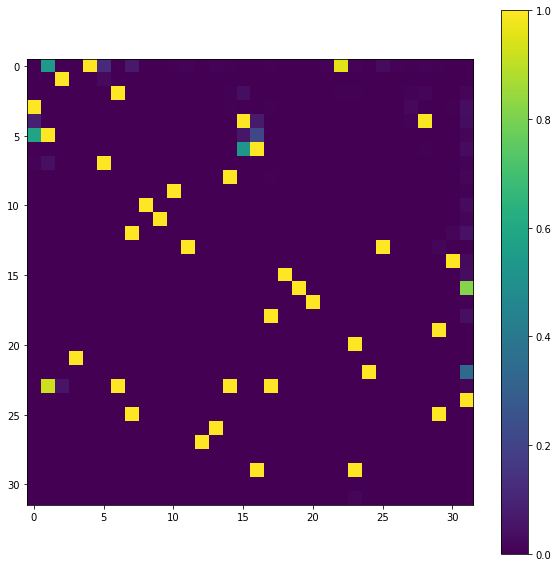

In [178]:
plot_gr(pred[1])

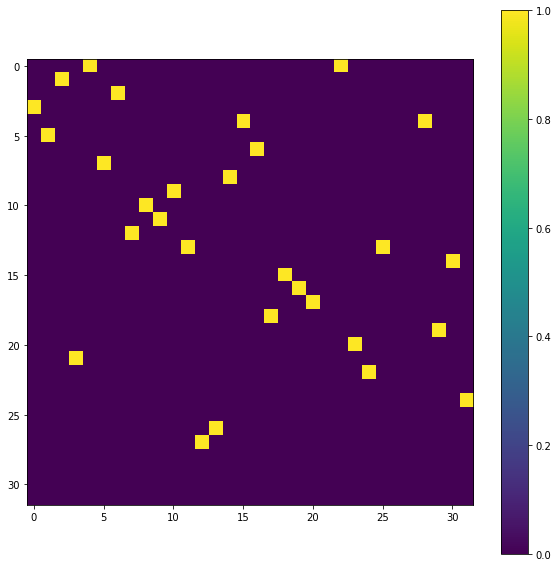

In [179]:
plot_gr(y_n[801])

In [186]:
from sklearn.metrics import roc_auc_score, f1_score,log_loss, accuracy_score, classification_report

In [181]:
pred[:,:,:,0].shape

IndexError: too many indices for array

In [216]:
log_loss(y_n[800:].reshape(200, -1), pred.reshape(200, -1))

91.34115054070949

In [217]:
# default unet default loss
f1_score(y_n[800:].flatten(), pred.flatten() > 0.5)

0.9504227517294388

In [218]:
# default unet default loss
print(classification_report(y_n[800:].flatten(), pred.flatten() > 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    199514
          1       0.97      0.94      0.95      5286

avg / total       1.00      1.00      1.00    204800



In [86]:
gr = np.load("../data/graphs/ES3_22.npy")[:32, :32]

sums = gr.sum(1)
sums[sums == 0] = 1
gr_n = gr / sums.reshape(-1, 1)

In [155]:
es_pred = sess.run(out, feed_dict={x : np.expand_dims(np.expand_dims(gr_n, 0), 3)} )[0,:,:,0]

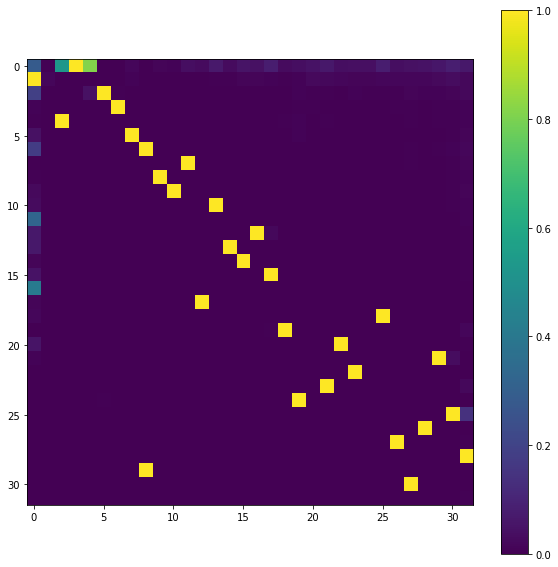

In [156]:
plot_gr(es_pred)